In [1]:
# LSTM Autoencoder for Offline Anomaly Detection

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, RepeatVector, TimeDistributed, Dense

# Configuration
DATA_DIR = "generated_datasets"
RESULTS_DIR = "results_offline"
os.makedirs(RESULTS_DIR, exist_ok=True)

WINDOW_SIZE = 30
CONTAMINATION = 0.05

In [2]:
# Create sliding windows for supervised-like learning
def create_sequences(data, window_size):
    sequences = []
    for i in range(len(data) - window_size):
        window = data[i:i + window_size]
        sequences.append(window)
    return np.array(sequences)

# Define the LSTM Autoencoder model
def build_model(window_size):
    input_layer = Input(shape=(window_size, 1))
    encoded = LSTM(64, activation='relu')(input_layer)
    decoded = RepeatVector(window_size)(encoded)
    decoded = LSTM(64, activation='relu', return_sequences=True)(decoded)
    output = TimeDistributed(Dense(1))(decoded)
    return Model(inputs=input_layer, outputs=output)

# Run LSTM autoencoder on time series
def run_lstm_autoencoder(ts):
    scaler = MinMaxScaler()
    ts_scaled = scaler.fit_transform(ts.reshape(-1, 1))

    X = create_sequences(ts_scaled, WINDOW_SIZE)
    X = X.reshape((X.shape[0], X.shape[1], 1))

    model = build_model(WINDOW_SIZE)
    model.compile(optimizer='adam', loss='mse')
    model.fit(X, X, epochs=10, batch_size=64, verbose=0)

    X_pred = model.predict(X)
    mse = np.mean(np.power(X - X_pred, 2), axis=(1, 2))
    return mse


Processing normality_1_daphnet.npy
1120/1120 ━━━━━━━━━━━━━━━━━━━━ 15s 12ms/step
Precision: 0.000, Recall: 0.000, F1: 0.000, AUC: 0.453


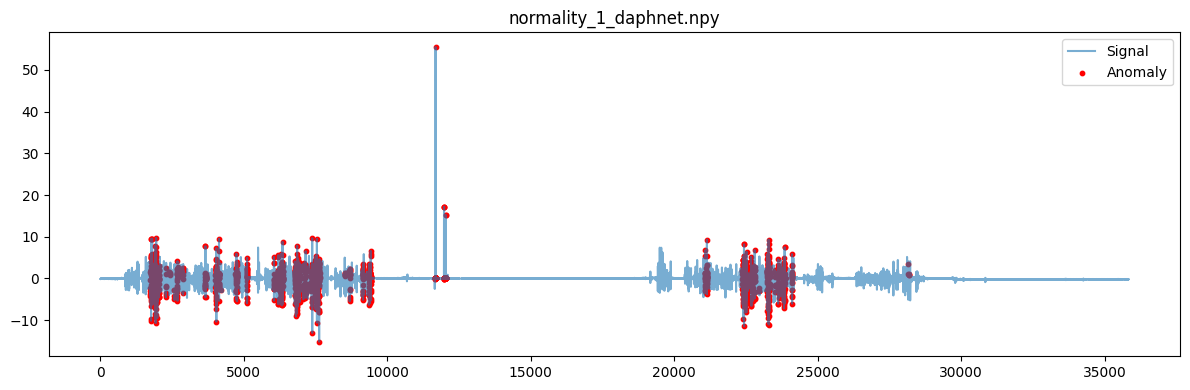


Processing normality_1_genesis.npy
506/506 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step
Precision: 0.048, Recall: 0.047, F1: 0.047, AUC: 0.496


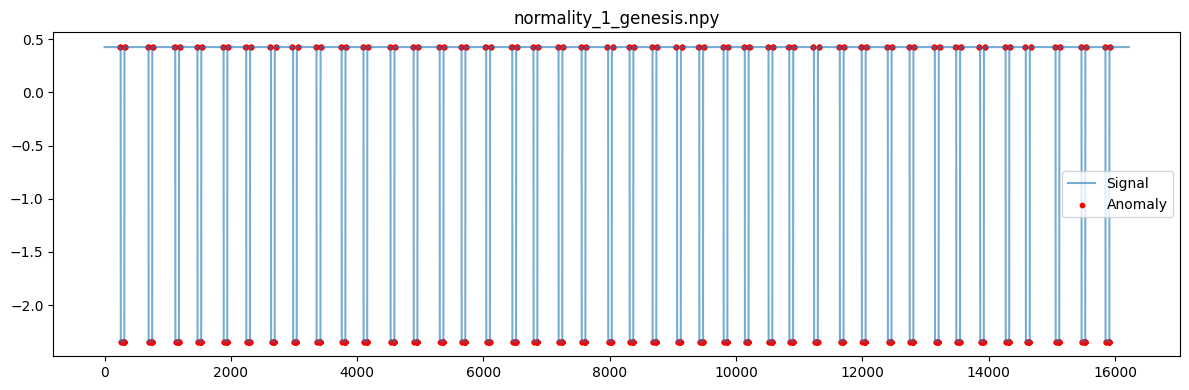


Processing normality_1_nasa-msl.npy
124/124 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step
Precision: 0.000, Recall: 0.000, F1: 0.000, AUC: 0.518


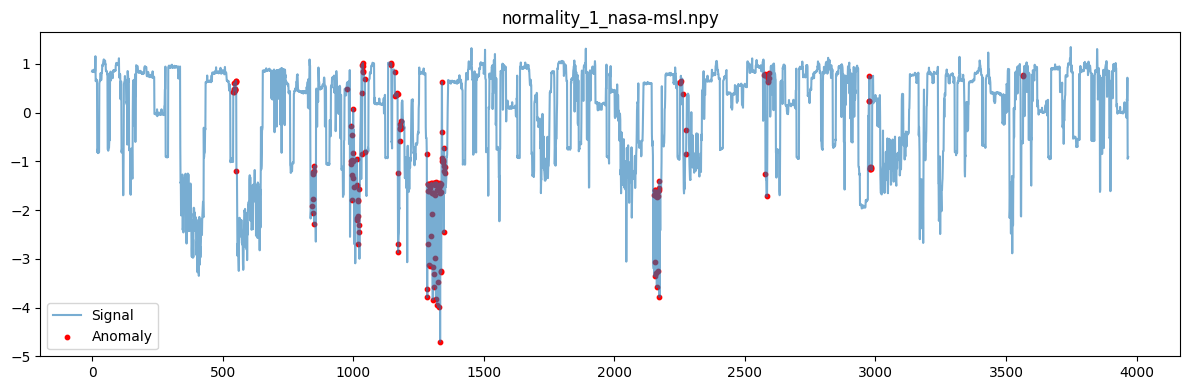


Processing normality_2_1_daphnet_genesis.npy
806/806 ━━━━━━━━━━━━━━━━━━━━ 24s 26ms/step
Precision: 0.000, Recall: 0.000, F1: 0.000, AUC: 0.420


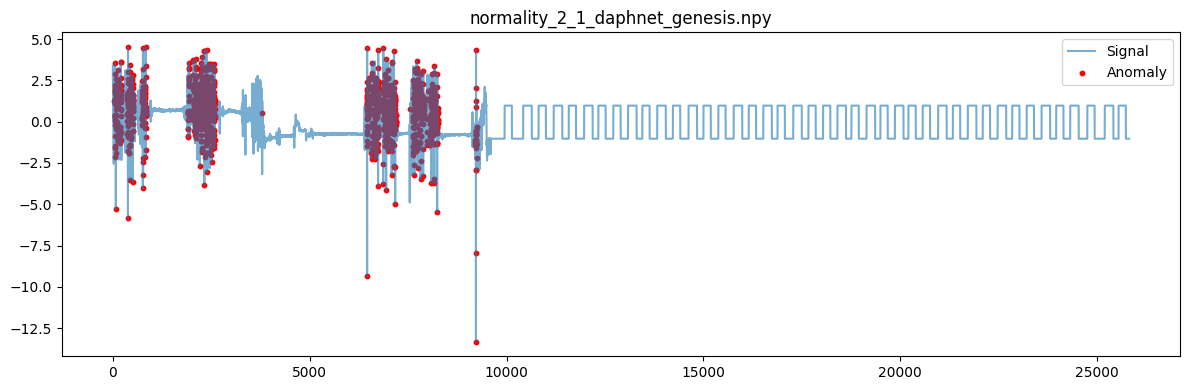


Processing normality_2_2_daphnet_nasa-msl.npy
1133/1133 ━━━━━━━━━━━━━━━━━━━━ 32s 26ms/step
Precision: 0.005, Recall: 0.005, F1: 0.005, AUC: 0.182


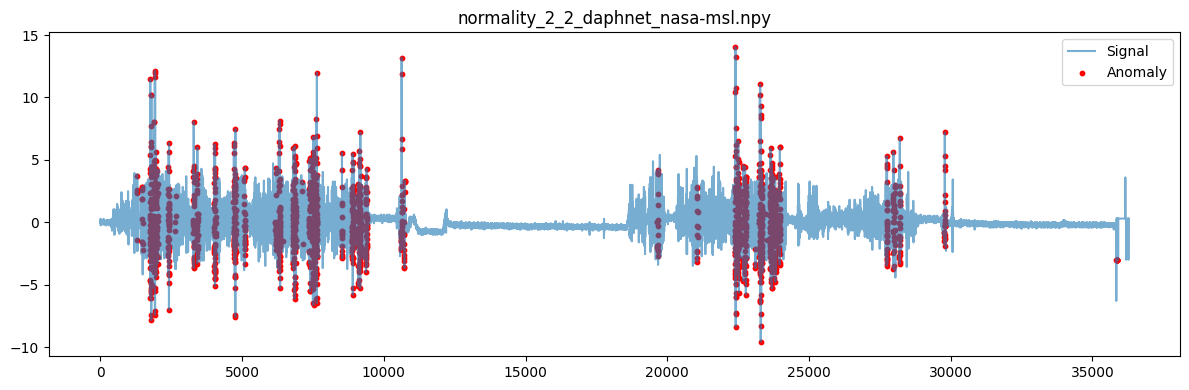


Processing normality_2_3_genesis_nasa-msl.npy
577/577 ━━━━━━━━━━━━━━━━━━━━ 19s 28ms/step
Precision: 0.000, Recall: 0.000, F1: 0.000, AUC: 0.075


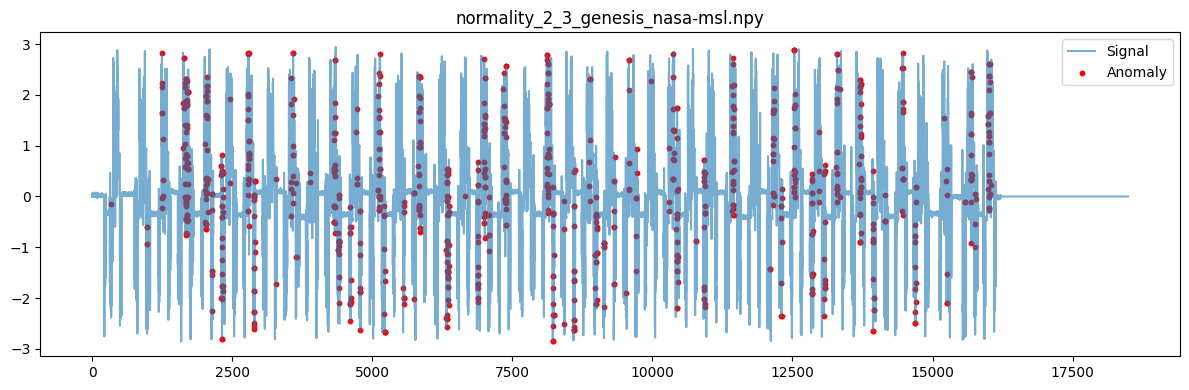


Processing normality_3_1_daphnet_genesis_nasa-msl.npy
1698/1698 ━━━━━━━━━━━━━━━━━━━━ 45s 25ms/step
Precision: 0.000, Recall: 0.000, F1: 0.000, AUC: 0.604


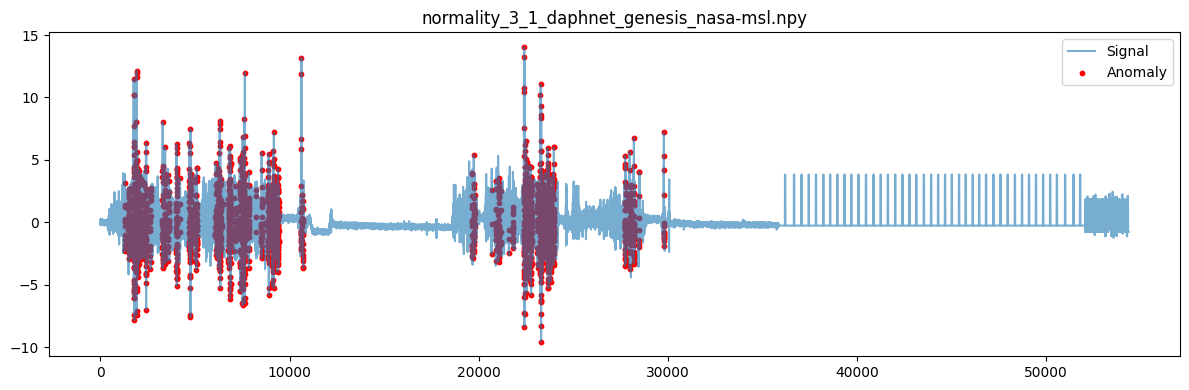


Processing normality_3_2_genesis_nasa-msl_daphnet.npy
1684/1684 ━━━━━━━━━━━━━━━━━━━━ 40s 22ms/step
Precision: 0.000, Recall: 0.000, F1: 0.000, AUC: 0.234


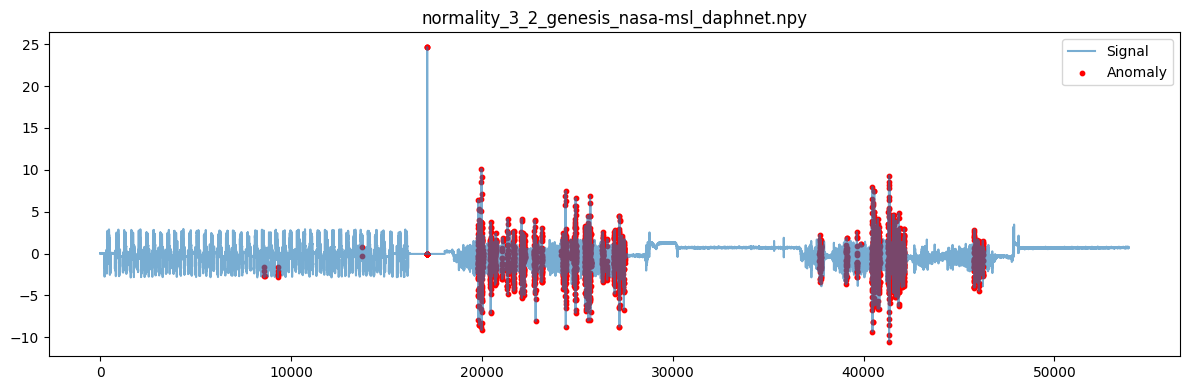


Processing normality_3_3_nasa-msl_daphnet_genesis.npy
871/871 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step
Precision: 0.000, Recall: 0.000, F1: 0.000, AUC: 0.426


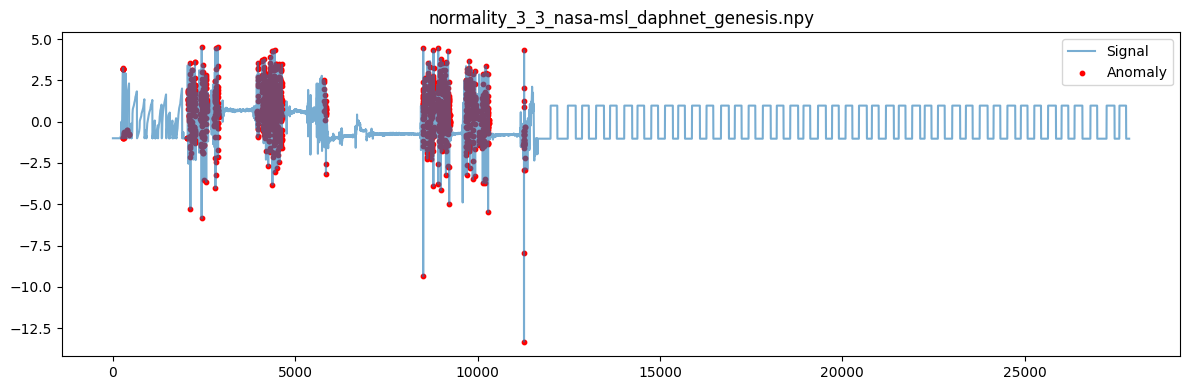

In [3]:
# Evaluation summary
summary = []

for fname in sorted(os.listdir(DATA_DIR)):
    if not fname.endswith(".npy") or "_boundaries" in fname:
        continue

    print(f"\nProcessing {fname}")
    ts = np.load(os.path.join(DATA_DIR, fname))

    try:
        scores = run_lstm_autoencoder(ts)
        threshold = np.percentile(scores, 100 * (1 - CONTAMINATION))
        preds = (scores > threshold).astype(int)

        labels = np.zeros_like(preds)
        labels[-int(len(labels) * CONTAMINATION):] = 1

        p = precision_score(labels, preds, zero_division=0)
        r = recall_score(labels, preds, zero_division=0)
        f = f1_score(labels, preds, zero_division=0)
        a = roc_auc_score(labels, scores) if len(set(labels)) > 1 else 0.0

        print(f"Precision: {p:.3f}, Recall: {r:.3f}, F1: {f:.3f}, AUC: {a:.3f}")

        plt.figure(figsize=(12, 4))
        plt.plot(ts, label="Signal", alpha=0.6)
        centers = np.where(preds == 1)[0] + WINDOW_SIZE // 2
        centers = centers[centers < len(ts)]
        plt.scatter(centers, ts[centers], color='red', s=10, label="Anomaly")
        plt.title(fname)
        plt.legend()
        plt.tight_layout()
        plt.show()

        summary.append(dict(dataset=fname, length=len(ts),
                            precision=round(p, 3),
                            recall=round(r, 3),
                            f1=round(f, 3),
                            auc=round(a, 3)))

    except Exception as e:
        print(f"Skipped due to error: {e}")

In [4]:
# Save results
if summary:
    df = pd.DataFrame(summary).set_index("dataset")
    display(df)
    df.to_csv(os.path.join(RESULTS_DIR, "lstm_offline_results.csv"))
else:
    print("No datasets were successfully processed.")

,length,precision,recall,f1,auc
dataset,,,,,
normality_1_daphnet.npy,35840,0.000,0.000,0.000,0.453
normality_1_genesis.npy,16220,0.048,0.047,0.047,0.496
normality_1_nasa-msl.npy,3969,0.000,0.000,0.000,0.518
normality_2_1_daphnet_genesis.npy,25820,0.000,0.000,0.000,0.420
normality_2_2_daphnet_nasa-msl.npy,36279,0.005,0.005,0.005,0.182
normality_2_3_genesis_nasa-msl.npy,18492,0.000,0.000,0.000,0.075
normality_3_1_daphnet_genesis_nasa-msl.npy,54363,0.000,0.000,0.000,0.604
normality_3_2_genesis_nasa-msl_daphnet.npy,53887,0.000,0.000,0.000,0.234
normality_3_3_nasa-msl_daphnet_genesis.npy,27871,0.000,0.000,0.000,0.426
